In [7]:
## import 
import os
import boto3
import pandas as pd
import joblib
from dotenv import load_dotenv
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
# Load environment variables
load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

# Initialize the S3 client
s3 = boto3.client(
    's3', 
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name='us-east-2'
)

# S3 bucket details
bucket_name = 'mle-e2e-2'

# Download test.csv from S3
test_file = 'inputs/test.csv'
local_test_file = 'inputs/test.csv'
s3.download_file(bucket_name, test_file, local_test_file)

# Download the model from S3
model_file = 'models/model.pkl'
local_model_file = 'models/model.pkl'
s3.download_file(bucket_name, model_file, local_model_file)

In [29]:
## model inference

df = pd.read_csv(local_test_file)
for i in range(1, 8):
    df[f'Temp_{i}d_ago'] = df['Temperature'].shift(i)
df.dropna(inplace=True)
X = df[[f'Temp_{i}d_ago' for i in range(1, 8)]]
y = df['Temperature'] 
model = joblib.load(local_model_file)
y_pred = model.predict(X)
y_pred_base1 = X.median(axis=1)
mae = mean_absolute_error(y, y_pred)
mae_base1 = mean_absolute_error(y, y_pred_base1)
print(f'MAE: {mae}')
print(f'MAE Baseline1: {mae_base1}')

MAE: 0.708993751456021
MAE Baseline1: 2.8322109290373136


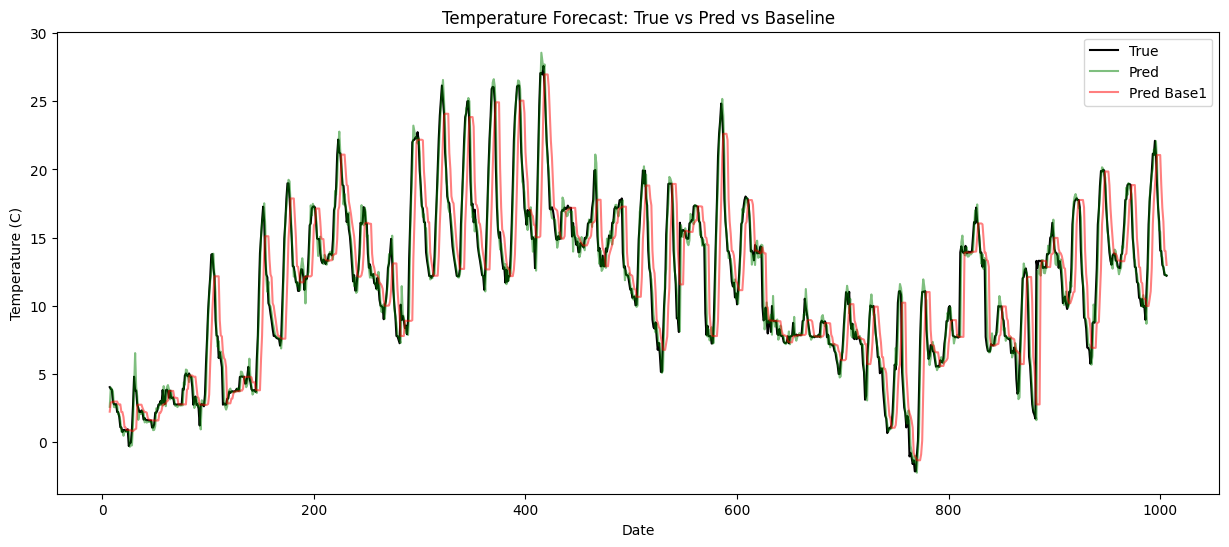

In [16]:
## visualize inference
plt.figure(figsize=(15, 6))
plt.plot(y.index[:1000], y[:1000], label='True', color='black', alpha=1)
plt.plot(y.index[:1000], y_pred[:1000], label='Pred', color='green', alpha=0.5)
plt.plot(y.index[:1000], y_pred_base1[:1000], label='Pred Base1', color='red', alpha=0.5)
plt.title('Temperature Forecast: True vs Pred vs Baseline')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

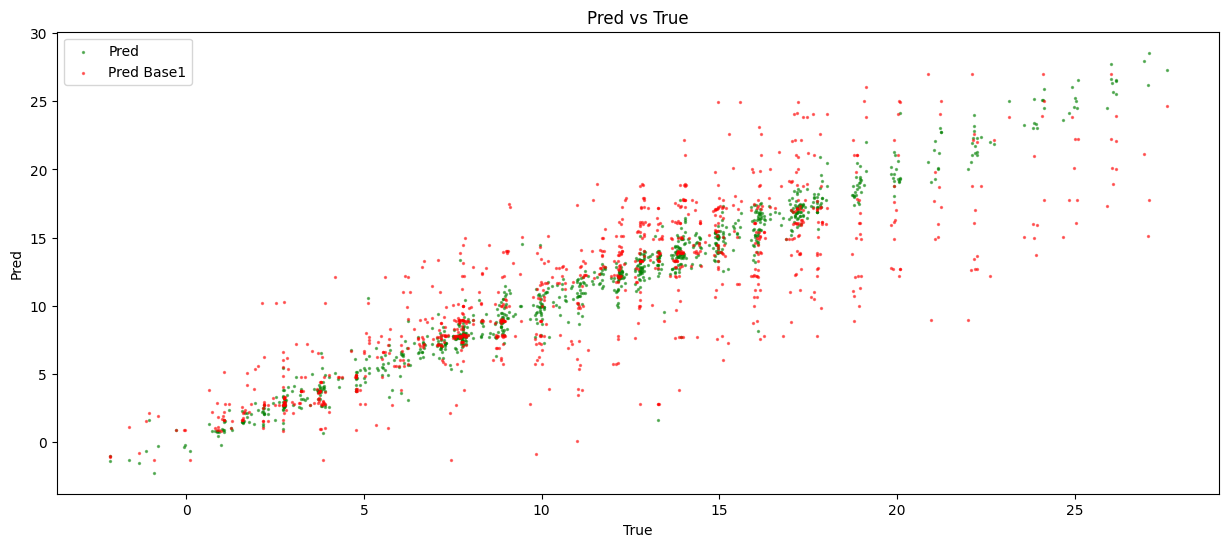

In [17]:
## visualize inference
plt.figure(figsize=(15, 6))
plt.scatter(y[:1000], y_pred[:1000], label='Pred', color='green', alpha=0.5, s=2)
plt.scatter(y[:1000], y_pred_base1[:1000], label='Pred Base1', color='red', alpha=0.5, s=2)
plt.title('Pred vs True')
plt.xlabel('True')
plt.ylabel('Pred')
plt.legend()
plt.show()


In [50]:
## save and upload inference
df_inference = pd.concat([
    X.reset_index(drop=True), 
    y.reset_index(drop=True), 
    pd.Series(y_pred, name='y_pred').reset_index(drop=True), 
    pd.Series(y_pred_base1, name='y_pred_base1').reset_index(drop=True)
    ], axis=1)
output_file = 'outputs/inference.csv'
df_inference.to_csv(output_file, index=False)
output_s3_file = 'outputs/inference.csv'
s3.upload_file(output_file, bucket_name, output_s3_file)
print(f"Uploaded {output_file} to S3 bucket {bucket_name} under {output_s3_file}")

Uploaded outputs/inference.csv to S3 bucket mle-e2e-2 under outputs/inference.csv
